# House Sales in King County, USA
### Predict house price using regression

W tym zadaniu będziemy szacować ceny domów.

In [1]:
import numpy as np 
import pandas as pd 
import xgboost as xg 
from sklearn.model_selection import train_test_split 
import shap
import sklearn
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


Dataframe zawiera dane typu :
 - 

Dane zawierają takie dane jak:
- id - unikalne id domu
- date - data sprzedaży domu
- price - cena sprzedanego domu


- bedrooms
- bathrooms - liczba łazienek, gdzie 0.5 znaczy łazienka bez prysznica
- sqft_living
- sqft_lot
- sqft_above - powierzchnia domu nad powierzchnią ziemi 
- sqft_basement
- yr_built
- yr_renovated
- floors - liczba pięter


- waterfront - Zmienna określająca czy mieszkanie wychodziło na nabrzeże
- view - ocena widoku [0, 4]
- condition - stan mieszkania [1, 5]
- grade - ocena zgodności budynku z projektem i jakości wykonania [1, 13]


- zipcode
- lat - Szerokość geograficzna
- long - Długość geograficzna
- sqft_living15 - powierzchnia mieszkań najbliższych 15 sąsiadów
- sqft_lot15 - powierzchnia ziemi najbliższych sąsiadów

Możemy wyszczególnić w tych danych 4 kategorie:
 - dane ogólne
 - specyfikacja domu
 - dane które są wyznaczane przez ludzi
 - dane o okolicy domu

Wynika stąd, że dane typu "id" powinny zostać usunięte z tego względu, że mogą powodować szum, z drugiej strony w id może być ukryta jakaś informacja, z której model mógłby wywnioskować cenę. Aby przygotować dane należy też udostępnić datę sprzedaży w bardziej przystępnym formacie.

In [3]:
df[['year', 'month', 'day']] = pd.DataFrame([ [int(x[0:4]), int(x[4:6]), int(x[6:8])] for x in df['date'].tolist() ])
df = df.drop(['date', 'id'], axis=1)
Y = df['price']
X = df.drop(['price'], axis=1)

In [4]:
df.groupby(['condition']).count()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
condition,,,,,,,,,,,,,,,,,,,,,
1,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30
2,172,172,172,172,172,172,172,172,172,172,...,172,172,172,172,172,172,172,172,172,172
3,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031,...,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031
4,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679,...,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679
5,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701,...,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701


In [5]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y,  
                      test_size = 0.3, random_state = 123) 

### 1. Wytrenowany model

In [6]:
rndForest = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
rndForest.fit(train_X, train_Y)

RandomForestRegressor(max_depth=6, n_estimators=10, random_state=0)

## 2. Predykcja dla wybranych obserwacji

In [7]:
test_Y[:2]

5506    532500.0
9279    410000.0
Name: price, dtype: float64

In [8]:
rndForest.predict(test_X[:2])

array([690304.38668679, 541175.72824823])

## 3. Dekompozycja dla SHAP dla wybranych obserwacji

In [9]:
explainer = shap.Explainer(rndForest.predict, test_X)
shap_values = explainer(test_X)

Permutation explainer: 6485it [03:09, 32.63it/s]                          


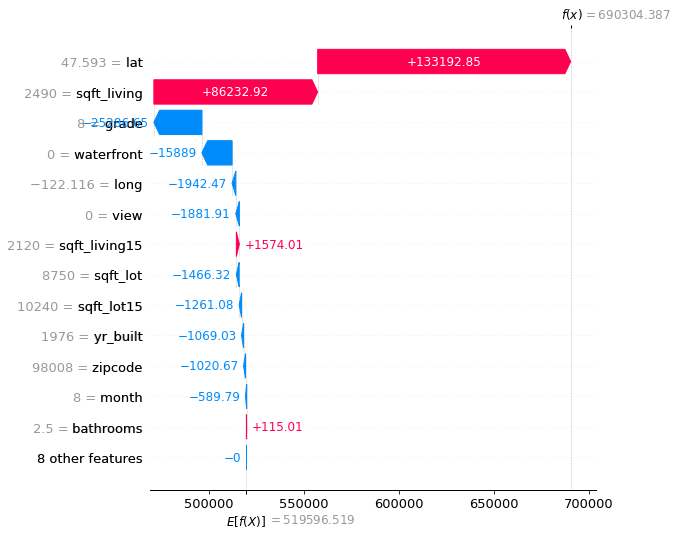

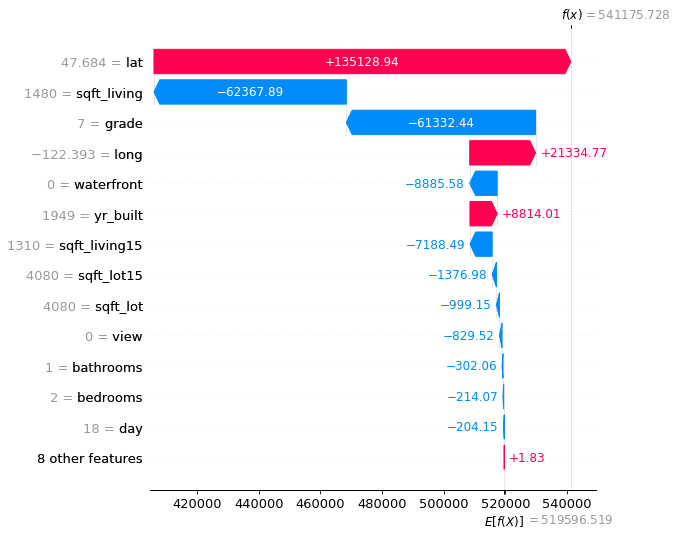

In [10]:
shap.plots.waterfall(shap_values[0], max_display=14)
shap.plots.waterfall(shap_values[1], max_display=14)

3060 [10 18 20 19  1  7  9 12 13  3  0  4 15  6 16 11  8 14  2 17  5]


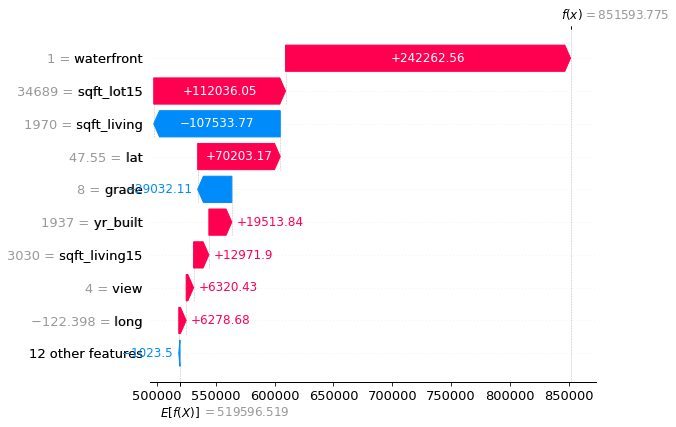

In [11]:
e = [2, 8, 14, 6] # 2 - sqft_living, 8 - grade, 14 - lat, 6 - view
for i in range(len(shap_values)):
    m = np.argsort(np.absolute(shap_values[i].values))
    if m[-1] not in e  and m[-2] not in e:
        print(i, m)
        shap.plots.waterfall(shap_values[i])
        break

Ciekawym wnioskiem może być fakt, że [2 - sqft_living, 8 - grade, 14 - lat, 6 - view] mają zawsze kluczowy wpływ na cenę domu. Jeśli dla każdego domu weźmiemy top2 zmiennych, to wśród nich zawsze będzie występować, któraś z powyższych zmiennych.

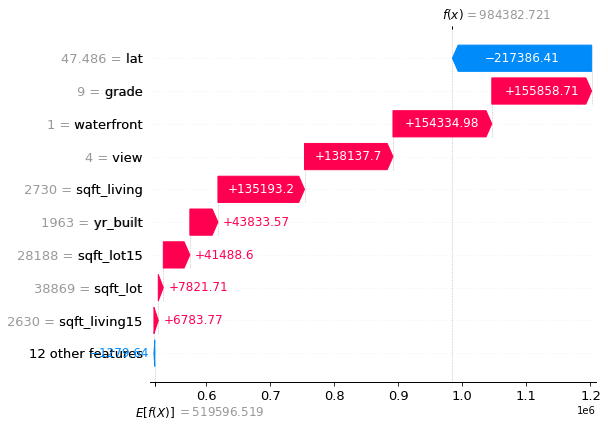

In [12]:
shap.plots.waterfall(shap_values[2508])

## 4. Przykład gdzie dwie najważniejsze zmienne są różne

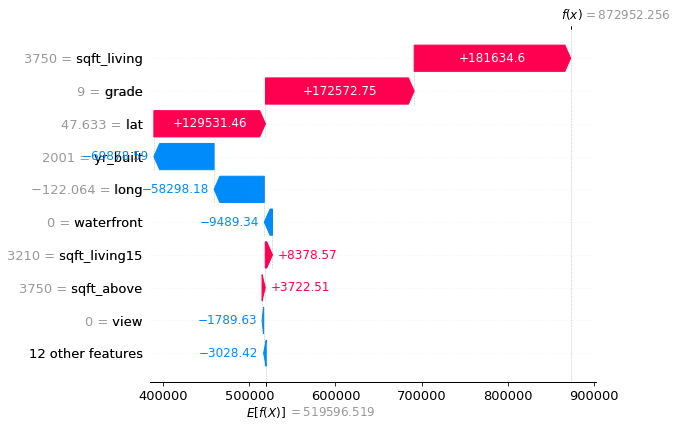

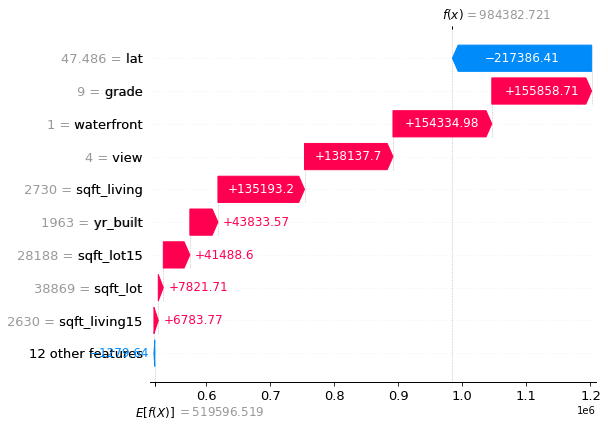

In [13]:
shap.plots.waterfall(shap_values[2])
shap.plots.waterfall(shap_values[2508]) # 14

W większości przypadków tam gdzie zmienna waterfront=0 (brak dostępu do nabrzeża/linii brzegowej) oraz widok jest oceniany na [0, 1, 2] wtedy najważniejszą rolę spełniają zmienne grade, sqft_living, lat(szerokość geograficzna). Natomiast w przypadkach kiedy widok=4 (najwyższa ocena) oraz waterfront=1 (dostęp do nabrzeża), wtedy te dwie zmienne mają największy wpływ na cenę nieruchomości.

## 5. Wybierzmy zmienną sqft_living

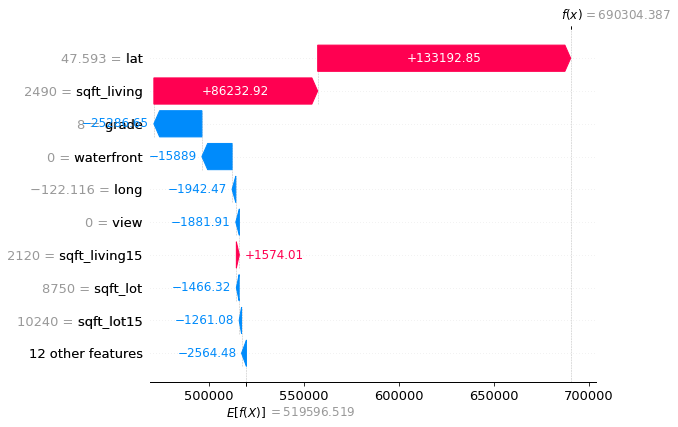

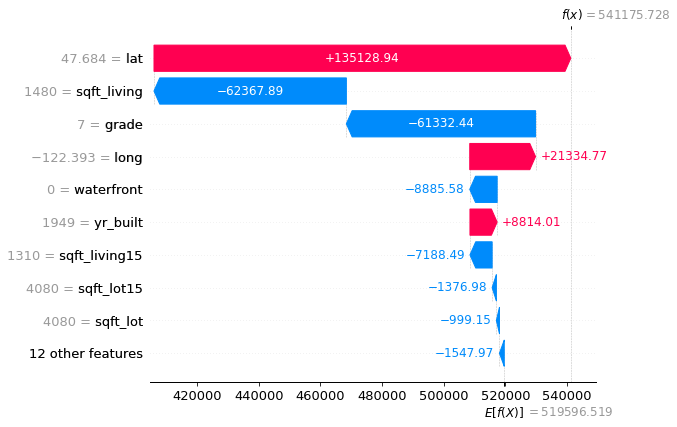

In [14]:
shap.plots.waterfall(shap_values[0])
shap.plots.waterfall(shap_values[1])

1480 sqft = 137.4965m² <br/> 2490 sqft = 231.3286m² <br/> Widać stąd, że jeśli dom jest mały (ma małą przestrzeń do życia) to wtedy zmienna "sqft_living" zmniejsza wartość domu, natomiast jeśli przestrzeń mieszkalna jest duża to wtedy cena domu wzrasta. 

## 6. Wytrenowanie regresji liniowej

In [15]:
linReg = sklearn.linear_model.LinearRegression()
linReg.fit(train_X, train_Y)

LinearRegression()

In [16]:
explainerLinReg = shap.Explainer(linReg.predict, test_X)
shap_valuesLinReg = explainerLinReg(test_X)

Permutation explainer: 6485it [03:10, 32.16it/s]                          


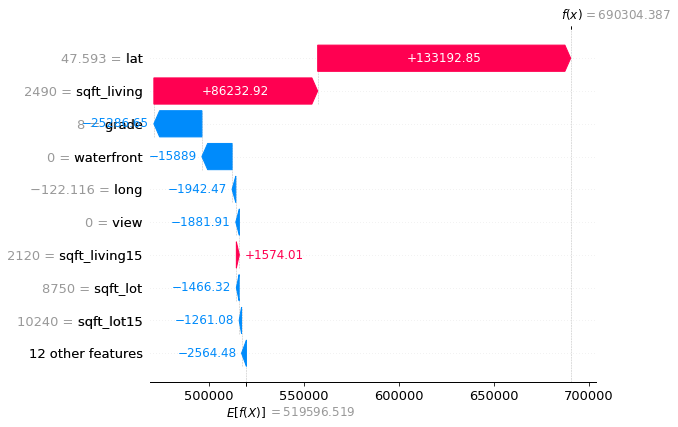

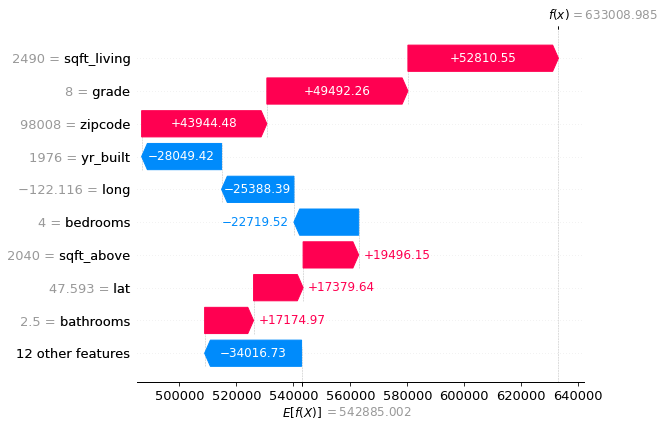

In [17]:
k=0
shap.plots.waterfall(shap_values[k])
shap.plots.waterfall(shap_valuesLinReg[k])

Widać, że model dla Regresji Liniowej ma więcej zmiennych, które mają wpływ na wynik w kluczowy sposób. Natomiast w lesie losowym występuje tylko kilka zmiennych, które mają ogromny wpływ na wynik, natomiast reszta zmiennych ma pomijalnie mały wpływ na wynik. Wynika to prawdopodobnie z faktu, że parametr max_depth jest ustawiony na 6 w przypadku lasu losowego. Dla lepszych resultatów warto by było zwiększyć parametry max_depth i n_estimators.